# Informe Tarea 2 #

En esta tarea se intetara construir un ecualizador para un canal de comuniciones. 

Para construir el ecualizador se simulara un esquema de comunicaciones fsk binario sobre un canal aditivo gaussiano como primera aproximacion. En una segunda instancia se espera tambien simular otros canales (Riciano y Rayleigh) y ver el comportamiento de la red neuronal.

Se intentarán tres aproximaciones al problema. Una sera intentar estimar el canal de comunicaciones (un canal de comunicaciones se puede representar en su modelo discreto como un 'tap delay filter') para esto se utilizara solo una neurona cuyos pesos se espera que sea la estimacion del canal. La segunda aproximacion sera convertir el demoulador en un problema de clasificacion, de esta forma los inputs a la red seran todas las muestras que representan un simbolo del fsk y el output sera 0 o 1 segun el simbolo que representa. En la tercera aproximacion, se intentara construir un ecualizador con una red de igual inputs a outputs, de esta forma se espera que la señal recibida una vez pasada por la red, se parezca mas a la señal real.

Para la primera aproximacion se utilizara el MSE (Mean Square Error) entre la señal estimada y la real como parametro de evaluación (en comparacion con el MSE entre la señal real y la pasada por el canal), y para la segunda aproximación se utilizará el bit error entre la clasificación con respecto el mensaje real (en comparación con el bit error entre el mensaje real y el mensaje recuperado por la demodulación fsk).

## Canal fsk binario con ruido gaussiano ##

In [1]:
from communication import Communication

import numpy as np
from numpy.random import sample
import random

In [2]:
#the following variables setup the system
Fc = 1000       #simulate a carrier frequency of 1kHz
Fbit = 50       #simulated bitrate of data
Fdev = 500      #frequency deviation, make higher than bitrate
N = 1000          #how many bits to send
Fs = 5000      #sampling frequency for the simulator, must be higher than twice the carrier frequency
A_n = 0.1      #noise peak amplitude

In [3]:
#generate some random data for testing
x = np.array([random.randint (0,1) for n in range(N)])

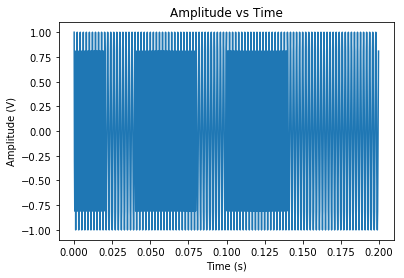

In [4]:
y = Communication.mod_fsk(x,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)
Communication.plot_signal(y, Fs, Fbit)

SNR = 13.968582dB


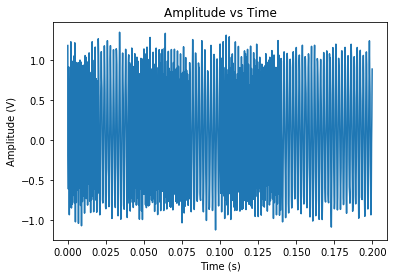

In [5]:
y_n, snr = Communication.noise_channel(y, A_n)
print("SNR = %fdB" % snr)
Communication.plot_signal(y_n, Fs, Fbit)

In [6]:
rx = Communication.demod_fsk(y_n,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)
bit_error = Communication.bit_error(x, rx)
mse = Communication.mse(y, y_n)
print("bit errors = %d" % bit_error)
print("bit error percent = %4.2f%%" % (float(bit_error)/float(len(x))*100))
print('mse = %1.5f' % mse)

bit errors = 55
bit error percent = 5.50%
mse = 0.02005


## Obtener un mse promedio ##

Debido a que el MSE y bit error son estadisticos es deseable obtener un promedio de varias realizaciones del canal.

In [7]:
ntimes = 100
bit_errors = np.zeros(ntimes)
mses = np.zeros(ntimes)
# print(bit_errors.shape)
for t in range(ntimes):
    #generate some random data for testing
    x = np.array([random.randint (0,1) for n in range(N)])
    y = Communication.mod_fsk(x,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)
    y_n, snr = Communication.noise_channel(y, A_n)
    rx = Communication.demod_fsk(y_n,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)
    bit_errors[t] = Communication.bit_error(x, rx)
    mses[t] = Communication.mse(y, y_n)
    
# print(bit_errs)
print('mean bit error: ', np.mean(bit_errors))
print('mean bit error percentage: %4.2f%%' % (np.mean(bit_errors) / N *100))
print('mean mse = %1.5f' % np.mean(mses))
    

mean bit error:  69.46
mean bit error percentage: 6.95%
mean mse = 0.02000


## Estimar el canal en base a una red neuronal ##

Se intentara estimar el canal de comunicaciones en base a una red neuronal simple compuesta de una neurona con 10 pesos. La idea es que al final del entrenamiento los pesos de la neurona sea el canal estimado.

Debido a que un canal de comunicaciones se puede modelar como un TDL (multiplicacion lineal entre el canal y el valor de la senial en el tiempo) es neceario invertir la funcion sigmoidea en la salida de la red, para que sea comparable con la senial inicial.

En una primera instancia se entrenara la red con toda la señal para analizar su resultado en base a su MSE.

In [8]:
def logit(p):
    return np.log(p/(1-p))
    

from neuron_network import NeuronNetwork
n_inputs = 10

network = NeuronNetwork(n_inputs, 0.05)
network.add_layer(1)

w = [1.0]
for i in range(n_inputs-1):
    w.append(0.0)

network.layers[0].neurons[0].weights = np.array(w)
network.layers[0].neurons[0].bias = 0.0

x = np.array([random.randint (0,1) for n in range(N)])
y = Communication.mod_fsk(x,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)
y_n, snr = Communication.noise_channel(y, A_n)

for epoch in range(3):
    print('epoch: ',epoch)
    print(network)
    for i in range(len(y)):

        expected = np.array([y[i]])
        if(i >= n_inputs-1):
            inputs = np.array(y_n[i+1-n_inputs:i+1])
        else:
            inputs = np.array(y_n[0:i+1])
            inputs = np.insert(inputs, 0, np.array([0.0 for x in range(n_inputs-(i+1))]), axis=0)
        
        inputs  = inputs[::-1]
            
        output = logit(network.feed(inputs))
        network.layers[0].neurons[0].output = output
        network.backpropagate_error(expected)
        network.update_weights()
        if(i == len(y)-1):
            print('    ',output, y_n[i], expected)


epoch:  0
neuron: 
{ 
	{ 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 } b: 0.0 z: None o: None d:None
}

     [ 0.23034034] -0.148458958503 [-0.30901699]
epoch:  1
neuron: [-0.14845896 -0.79505812  0.80776044  0.51059789 -0.89579686  0.30351559
  0.98292759 -0.72566428 -0.1932083   0.8641888 ]
{ 
	{ 0.31122646836 0.0332604725528 -0.0569405906887 0.0209618612215 -0.00301630627376 -0.055490020285 0.0012035593887 0.00190213808077 -0.0143974520512 0.0217333032833 } b: [ 0.30361698] z: [ 0.23034034] o: [ 0.23034034] d:[-0.09561925]
}

     [ 0.23034034] -0.148458958503 [-0.30901699]
epoch:  2
neuron: [-0.14845896 -0.79505812  0.80776044  0.51059789 -0.89579686  0.30351559
  0.98292759 -0.72566428 -0.1932083   0.8641888 ]
{ 
	{ 0.31122646836 0.0332604725528 -0.0569405906888 0.0209618612215 -0.00301630627374 -0.0554900202851 0.00120355938876 0.00190213808071 -0.0143974520512 0.0217333032832 } b: [ 0.30361698] z: [ 0.23034034] o: [ 0.23034034] d:[-0.09561925]
}

     [ 0.23034034] -0.148458958503 [

In [9]:
print(network)

neuron: [-0.14845896 -0.79505812  0.80776044  0.51059789 -0.89579686  0.30351559
  0.98292759 -0.72566428 -0.1932083   0.8641888 ]
{ 
	{ 0.31122646836 0.0332604725528 -0.0569405906888 0.0209618612215 -0.00301630627374 -0.0554900202851 0.00120355938876 0.00190213808071 -0.0143974520512 0.0217333032832 } b: [ 0.30361698] z: [ 0.23034034] o: [ 0.23034034] d:[-0.09561925]
}



In [10]:
y_est = np.copy(y)
for i in range(len(y)):

    if(i >= n_inputs-1):
        inputs = np.array(y_n[i+1-n_inputs:i+1])
    else:
        inputs = np.array(y_n[0:i+1])
        inputs = np.insert(inputs, 0, np.array([0.0 for x in range(n_inputs-(i+1))]), axis=0)

    inputs  = inputs[::-1]
    y_est[i] = logit(network.feed(inputs))
    
print(y[0:10])
print(y_est[0:10])

# MSE senial estimada con senial real
mse = Communication.mse(y, y_est)
print('mse = %1.5f' % mse)

# MSE senial recibida con senial real
mse = Communication.mse(y, y_n)
print('mse = %1.5f' % mse)

[ 1.         -0.30901699 -0.80901699  0.80901699  0.30901699 -1.
  0.30901699  0.80901699 -0.80901699 -0.30901699]
[ 0.65526007  0.31187705 -0.01205162  0.60041164  0.48409846 -0.08028325
  0.39031271  0.67634051 -0.01422793  0.21692744]
mse = 0.28854
mse = 0.02001


El MSE estimado da mayo al MSE original. Lo cual nos da un indicio de que el canal no puede ser estimado de esta forma. La principal razon por la cual se cree que esto no funciona es porque se esta realizando la estimacion sobre un canal simple solo con ruido Gaussiano y en general el modelo de un canal a traves de TDL ocurre para canales mas complejos (Riciano o Rayleigh).

Como trabajos futuros para esta aproximación se espera:

- Simular canales Ricianos y Rayleigh
- 

## Clasificar la señal en datos digitales##

El objetivo es clasificar

In [20]:
import scipy.signal.signaltools as sigtool
import scipy.signal as signal

x = np.array([random.randint (0,1) for n in range(N)])
y = Communication.mod_fsk(x,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)
y_n, snr = Communication.noise_channel(y, A_n)
y_diff = np.diff(y_n,1)
y_env = np.abs(sigtool.hilbert(y_diff))
# h=signal.firwin( numtaps=100, cutoff=Fbit*2, nyq=Fs/2)
# y_filtered=signal.lfilter( h, 1.0, y_env)

rx = Communication.demod_fsk(y_n,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)

(100000,)
(100000,)


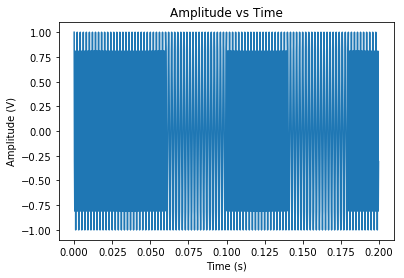

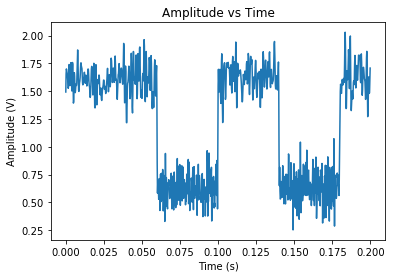

In [21]:
y_env = np.append(y_env, np.array([[y_env[-1]]]))
# y_filtered = np.append(y_filtered, np.array([[y_filtered[-1]]]))

print(y_n.shape)
print(y_env.shape)
# print(y_filtered.shape)

Communication.plot_signal(y, Fs, Fbit)
Communication.plot_signal(y_env, Fs, Fbit)
# Communication.plot_signal(y_filtered, Fs, Fbit)

In [22]:
step = int(Fs/Fbit)
print(step)

inputs = np.array([y_env[step*i:step*(i+1)] for i in range(int(len(y_env)/step))])
inputs.shape


100


(1000, 100)

In [23]:
n_inputs = step

network = NeuronNetwork(n_inputs, 0.5)
network.add_layer(n_inputs)
# network.add_layer(int(step/2))
# network.add_layer(int(step/3))
network.add_layer(100)
network.add_layer(10)
network.add_layer(1)

for epoch in range(1000):
    if (epoch %100 == 0):
        print('epoch: ',epoch)
    for i in range(10):
        expected = np.array([x[i]])
        inp  = inputs[i]
        output = network.feed(inp)
        network.backpropagate_error(expected)
        network.update_weights()
        if( (epoch%100 == 0) and (i==0 or i==1 or i==2 or i==3) ):
            print(output,expected)
#         print('epoch: ', epoch, output, expected)

epoch:  0
[ 0.99930778] [0]
[ 0.99930515] [0]
[ 0.99930249] [0]
[ 0.99929982] [1]
epoch:  100
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  200
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  300
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  400
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  500
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  600
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  700
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  800
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]
epoch:  900
[ 0.41948919] [0]
[ 0.29178859] [0]
[ 0.22822703] [0]
[ 0.19163079] [1]


In [24]:
sumTrue = 0
errors = np.array([])
count = 0
for i in range(N):
    count +=1
    inp  = inputs[i]
    raw_output = network.feed(inp)
    output = [(1.0 if x > 0.5 else 0.0) for x in raw_output.tolist()]
    expected = np.array(x[i])

    errors = np.append(errors, np.sum(np.abs(expected - raw_output)))

    if output[0] == expected:
        sumTrue += 1
        
#     if expected == 1:
#         print(i)

precision = sumTrue / count
promError = np.mean(np.abs(errors))
print('prec: ', str(precision), 'error: ', str(promError))

prec:  0.48 error:  0.503220432511


No se obtienen buenos resultados tampoco de esta forma.

## Disminuir el SNR a traves de un equalizador basado en RN ##

El objetivo de este experimento, es intentan bajar el snr entre la señal recibida y la real, haciendo pasar la señal recibida por una red neuronal de igual inputs e outputs, para esto se utilizara 10 inputs y 10 outputs y un porcentaje de señal como entrenamiento.

In [25]:
import scipy.signal.signaltools as sigtool
import scipy.signal as signal

x = np.array([random.randint (0,1) for n in range(N)])
y = Communication.mod_fsk(x,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)
y_n, snr = Communication.noise_channel(y, A_n)
y_diff = np.diff(y_n,1)
y_env = np.abs(sigtool.hilbert(y_diff))

rx = Communication.demod_fsk(y_n,Fs=Fs, Fbit=Fbit, Fc=Fc, Fdev=Fdev)

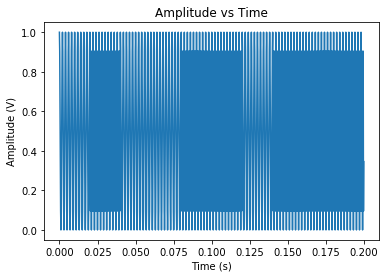

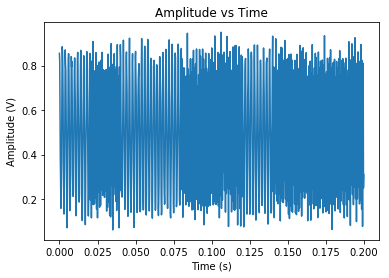

In [26]:
# Convert y and y_n to 0 to 1 

y = (y - np.min(y))/(np.max(y)-np.min(y))
y_n = (y_n - np.min(y_n))/(np.max(y_n)-np.min(y_n))

Communication.plot_signal(y, Fs, Fbit)
Communication.plot_signal(y_n, Fs, Fbit)

In [27]:
n_inputs = 10

network = NeuronNetwork(n_inputs, 0.5)
network.add_layer(n_inputs)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)


for epoch in range(100):
    if (epoch %10 == 0):
        print('epoch: ',epoch)
    for i in range(0,5000,10):
        expected = y[i:i+10]
        inp  = y_n[i:i+10]
        output = network.feed(inp)
        network.backpropagate_error(expected)
        network.update_weights()
        if( (epoch%10 == 0) and i== 0):
            print(np.mean(output - expected))
        if( (epoch%10 == 0) and i== 100):
            print(np.mean(output - expected))

epoch:  0
0.495064997228
0.493951059129
epoch:  10
9.70899459615e-06
2.61014631995e-05
epoch:  20
-0.000646328218184
0.000919707953623
epoch:  30
0.000383557873585
-0.000595517376934
epoch:  40
-0.00145618237629
0.00152577000303
epoch:  50
-0.000612885361311
0.00065472878984
epoch:  60
-0.00019508657157
0.000198919957523
epoch:  70
-5.00871213506e-05
3.04005321645e-05
epoch:  80
1.91852227285e-05
-6.3074451138e-05
epoch:  90
4.94549897919e-05
-7.07289584634e-05


In [28]:
z= np.array([])

for i in range(0,100000,10):
    inp  = y_n[i:i+10]
    output = network.feed(inp)

    z =np.append(z, output)
    


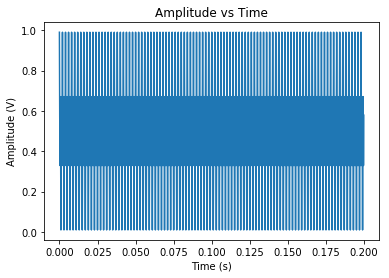

In [29]:
Communication.plot_signal(z, Fs, Fbit)

In [30]:
# MSE entre la señal equalizada z y la señal real
Communication.mse(z, y)

0.063306257893153792

In [31]:
# MSE entre la señal recibida y la señal real
Communication.mse(y_n, y)

0.010406151235563675

A pesar que no se obtuvo un MSE mayor, pareciera ser que esta aproximacion es la que mejor resultados da. Como trabajo futuro espera mejorar la simulacion agregando un canal FIR, Riciano o Rayleigh.

Se intentará a continuacion la misma tecnica pero con la señal pasada por el detector de envolvente.


In [32]:
y_diff_real = np.diff(y,1)
y_env_real = np.abs(sigtool.hilbert(y_diff_real))

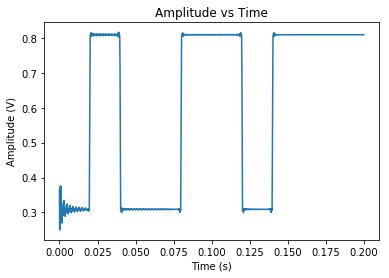

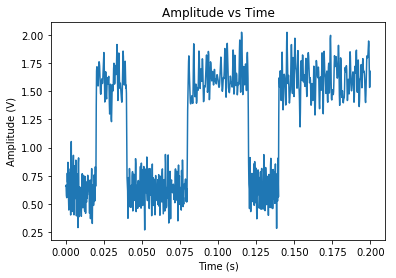

In [33]:
Communication.plot_signal(y_env_real, Fs, Fbit)
Communication.plot_signal(y_env, Fs, Fbit)

In [34]:
y_env = np.append(y_env, np.array([[y_env[-1]]]))
y_env_real = np.append(y_env_real, np.array([[y_env_real[-1]]]))

In [41]:
y_env_real = (y_env_real - np.min(y_env_real))/(np.max(y_env_real)-np.min(y_env_real))
y_env = (y_env - np.min(y_env))/(np.max(y_env)-np.min(y_env))

print(y_env.shape)
print(y_env_real.shape)


(100000,)
(100000,)


In [42]:
n_inputs = 10

network = NeuronNetwork(n_inputs, 0.5)
network.add_layer(n_inputs)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)
network.add_layer(10)


for epoch in range(100):
    if (epoch %10 == 0):
        print('epoch: ',epoch)
    for i in range(1000,6000,10):
        expected = y_env_real[i:i+10]
        inp  = y_env[i:i+10]
        output = network.feed(inp)
        network.backpropagate_error(expected)
        network.update_weights()
        if( (epoch%10 == 0) and i== 1000):
            print(np.mean(output - expected))
        if( (epoch%10 == 0) and i== 2000):
            print(np.mean(output - expected))

epoch:  0
0.199037933292
0.822889842322
epoch:  10
-0.156370118205
0.526090584542
epoch:  20
-0.163841587485
0.536572779015
epoch:  30
-0.155227380313
0.556868645694
epoch:  40
-0.155242520149
0.556983490164
epoch:  50
-0.155250720366
0.557032645562
epoch:  60
-0.155255847444
0.557060122013
epoch:  70
-0.155259353344
0.557077675909
epoch:  80
-0.155261900649
0.557089856446
epoch:  90
-0.155263834528
0.557098800347


In [43]:
z= np.array([])

for i in range(0,100000,10):
    inp  = y_n[i:i+10]
    output = network.feed(inp)

    z =np.append(z, output)
    


In [45]:
# MSE entre la señal equalizada z y la señal real
Communication.mse(z, y_env)

0.078718156697580602

In [46]:
# MSE entre la señal equalizada z y la señal real
Communication.mse(y_env_real, y_env)

0.020193725683891738

## Conclusiones ##

Los resultados no han sido como lo esperado (la senial estimada en todos los casos es peor que la senial redibida). Se espera obtener mejores resultados una vez se haya implementado un canal de algun tipo en el simulador, ya que al parecer solo el ruido gaussiano no se puede disminuir utilizando estas tecnicas.

Sin embargo por los resultados, la tercera tecnica es la que parece mas efectiva a ser utilizada una vez que el canal este implementado. Como trabajo futuro se espera implementar esta tecnica en conjunto con una red recurrente, que es lo que mas se ha visto en la literatura que se utiliza.